### CUNY Data 620 - Web Analytics, Summer 2020
**Group Project 1**  
**Prof:** Alain Ledon  
**Members:** Misha Kollontai, Amber Ferger, Zach Alexander, Subhalaxmi Rout  

### Instructions
1. Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
3. What can you infer about each of the distinct groups?

### Dataset
* **Source**: [Hollywood Film Music Dataset](http://networkdata.ics.uci.edu/netdata/html/movies.html)
* **Format**: The network was stored as an .RData file. We converted the file components to individual text files, creating lists for all composers, producers, and the interaction matrix. We then loaded these text files into jupyter and created a bipartite graph. 
* **Description**: This is a 2-mode network that contains the collaboration of 40 composers of film scores and the 62 producers who produced a minimum of five movies in Hollywood, 1964-1976. A line between a composer and a producer indicates that the former created the soundtrack for the movie produced by the latter. The line values indicate the number of movies by one producer for which the composer created the music in the period 1964- 1976.
* **Nodes**: Each node corresponds to either a composer or producer.  
* **Edges**: Each edge is assigned one weight -- the number of films collaborated on together.

### Motivation
We aim to do the following:  

1) Load the graph as a bipartite network and clearly identify the nodes and edges associated with composers and producers.  

2) Use the "Island Method" outlined in our book, "Social Network Analysis for Startups" to subset our larger graph into a smaller one based on our edge attribute. We'll utilize the edge weight (# of films collaborated on together), to reduce our network to only bipartite relationships between composers and producers that collaborated on at least 2 films together.  

3) We will then make inferences about each of the ego networks that result from this subsetting method. Particularly, we'd like to answer (1) whether or not certain ego networks show higher productivity (productivity = # of films collaborated on together) than others. (2) whether or not these subgroups work in isolation or typically collaborate with the broader network.

### Importing packages

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as spy
import numpy as np
import statistics
from networkx.algorithms import bipartite
from networkx.algorithms import traversal

### Loading in the text files

Since the data could only be downloaded as an .RData file, we first loaded the file into R, isolated the node and edge components, and exported them as text files. With these text files saved in our working directory, we then opened them in our Jupyter notebook and saved the producers and composers (nodes) to lists. Additionally, we loaded in our interaction matrix and also saved this to a list. Finally, in order for us to generate our bipartite graph, we decided to convert these lists to strings for later use.

In [2]:
composerFile = "data/composers.txt"

composers = []
composerfile = open(composerFile, 'r') 
for line in composerfile.readlines(): 
    for element in line[0:-1].split('\t'):
        composers.append(element)
composers = [item for item in composers if composers not in ['\n', '']]
composers = [string for string in composers if string != ""]

In [3]:
producerFile = "data/producers.txt"

producers = []
producerfile = open(producerFile, 'r') 
for line in producerfile.readlines(): 
    for element in line[0:-1].split('\t'):
        producers.append(element)
producers = [item for item in producers if producers not in ['\n', ',']]
producers = [string for string in producers if string != ""]

In [4]:
interaction_matrix = "data/matrix.txt"

interaction_mat = []
interactfile = open(interaction_matrix, 'r') 
for line in interactfile.readlines(): 
    for element in line[0:-1].split('\n'):
        interaction_mat.append(element)
interaction_mat = [item for item in interaction_mat if interaction_mat not in ['\n', '']]
interaction_mat = [string for string in interaction_mat if string != ""]

In [5]:
producers = "\n".join(producers)
composers = "\n".join(composers)
interaction_mat = "\n".join(interaction_mat)

### Constructing the bipartite network
With our separate components loaded in as strings, we then were able to utlize these in our function below to generate our bipartite graph. By setting up an empty graph with the size based on the number of composers (40) and producers (62), we then were able to create separate lists for our two composer/producer components, load in our interaction matrix, and connect our nodes to our edges. Since the interaction matrix had values from 1-7 (indicating the # of collaborations on films between a composer/producer duo), we were able to assign an edge weight based on this value.

In [6]:
def hollywood_graph(create_using=None, **kwds):
    composers_num=40
    producers_num=62
    g=nx.generators.empty_graph(composers_num+producers_num,create_using=create_using,**kwds)
    g.clear()
    g.name="Hollywood Film Music"
    
    # loading the women's names
    producers_list=producers

    # loading the club names
    composers_list=composers

    # loading the interaction matrix
    interaction_matrix=interaction_mat
    
    # creating a list of women names
    c={}
    n=0
    for name in composers_list.split('\n'):
        c[n]=name
        n+=1

    # creating a list of club names
    p={}
    n=0
    for name in producers_list.split('\n'):
        p[n]=name
        n+=1
        
    # parsing our interactions matrix, adding edges
    row=0
    for line in interaction_matrix.split('\n'):
        thisrow=list(map(int,line.split()))
        for col in range(0,len(thisrow)):
            if thisrow[col]>0:
                g.add_edge(p[row],c[col], weight=thisrow[col])
        row+=1
    return (g, list(p.values()),list(c.values()))

In [7]:
(g, producers, composers)=hollywood_graph()

### Network characteristics

After running our function to generate our bipartite graph, we can see below that the network has 101 nodes and 192 edges. The average degree of the network is about 4, which indicates that many composers and producers tend to be less connected to one another (in comparison to a social media network).

In [8]:
print(nx.info(g))

Name: Hollywood Film Music
Type: Graph
Number of nodes: 101
Number of edges: 192
Average degree:   3.8020


In [9]:
nx.is_bipartite(g)

True

After checking to ensure our graph is bipartite in structure, we can also make sure that our edges have a weight attribute assigned. We can see below in an example of one of our edges between a composer and producer that this is indeed true.

In [10]:
g.edges[('Rosenberg, A.', 'Goldsmith, J.')]

{'weight': 3}

### An initial look at our bipartite network

With the structure ready, we can assign colors to both our composers and producers in order to distinguish between different nodes when we generate some graph visualizations. By adding a node attribute of 1 to producers, and a 0 to composers, we can then iterate through our nodes and append a color attribute to each node.

In [11]:
c = bipartite.color(g)
nx.set_node_attributes(g, c, 'bipartite')

In [12]:
def color_nodes(graph, node_list):
    for n in graph.nodes:
        if graph.nodes[str(n)]['bipartite'] == 1:
            node_list.append('lightblue')
        else:
            node_list.append('lightcoral')

In [13]:
comp_prod = []
color_nodes(g, comp_prod)

Next, we can display our bipartite graph in a circular layout, showing connections between composers and producers.

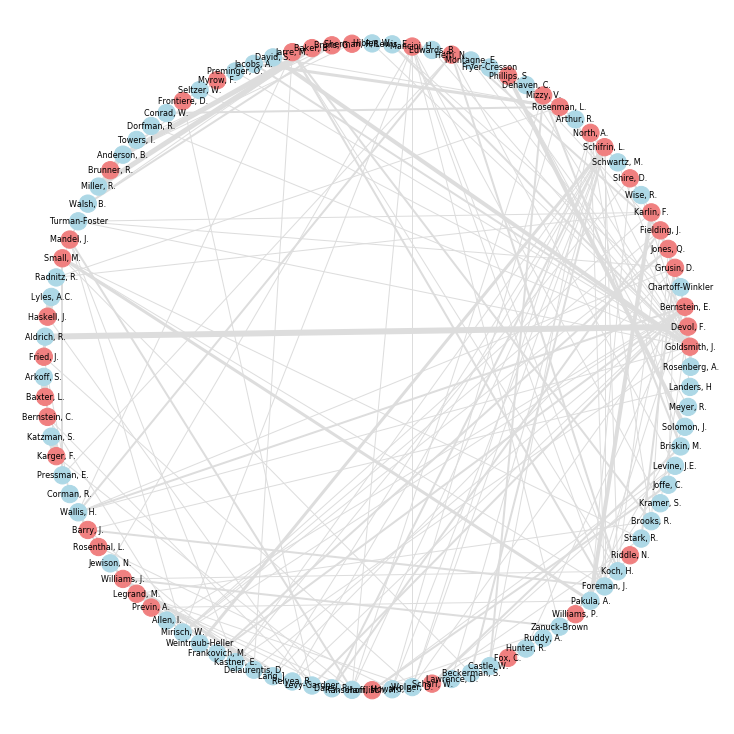

In [14]:
plt.rcParams['figure.figsize'] = [10, 10]
weights = []
weights = [edata['weight'] for f,to,edata in g.edges(data=True)]
nx.draw_circular(g, with_labels='true', node_color=comp_prod, edge_color="#dddddd", font_size=8, width = weights)

We can already start to see that some composers have broader networks than others, and collaborate with a larger number of producers. However, we can continue to run more visualizations and some analysis to make more concrete conclusions.

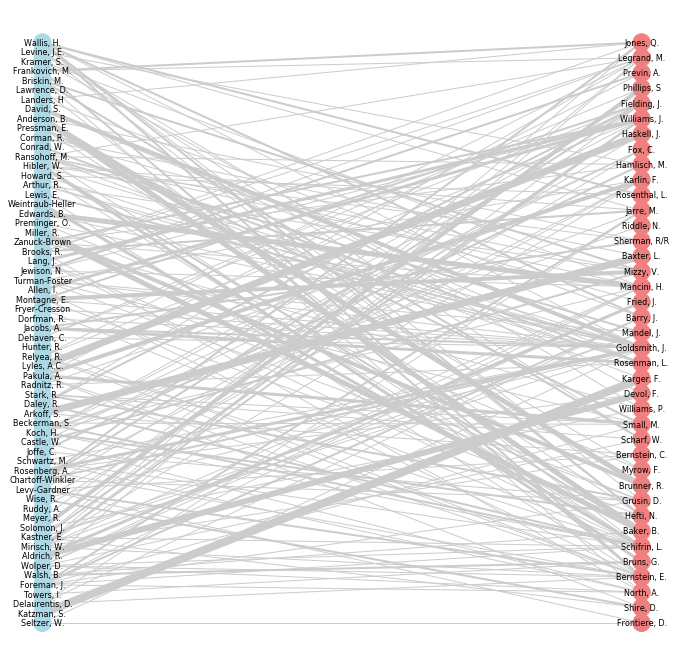

In [15]:
top = nx.bipartite.sets(g)[0]
pos = nx.bipartite_layout(g,top)
plt.rcParams['figure.figsize'] = [12, 12]
plt.axis('off')
nx.draw_networkx(g,pos, node_color=comp_prod, edgecolor='#bbbbbb', edge_color="#cccccc", font_size=8, width = weights)

### Using the Island Method to further subset our network

With some initial observations of our network, we can quickly see that there are a lot of one-off interactions between composers and producers, and this provides a good opportunity for us to further subset our data to hone in on certain ego networks that have arisen in our broader network. Before doing so, we needed to rework the weight value to ensure we could conduct the "Island Method" properly.

In [16]:
def trim_edges(g, weight=1):
        g2=nx.Graph()
        for f, to, edata in g.edges(data=True):
                if edata['weight'] > weight:
                        key, val = next(iter(edata.items()))
                        g2.add_edge(f,to,weight = val)
        return g2

With the weights trimmed, we can now iterate through our edge attributes and define the various levels of interactions between composers and producers. We define the minimum edge weight at 1 and the maximum edge weight at 7. We assign a step = 1 for our iterations, to show the islands created by adding an additional step in our edge weights. Then, we iterate through our edges, and identify the number of nodes remaining if a certain threshold in our edge weight is reached. For example, we can see that if we removed all one-off interactions between composers and producers in the network, we would see that 71 nodes would be remaining across 15 different islands.

In [17]:
def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]

    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)

    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [18]:
islands=island_method(g)
for i in islands:
    # print the threshold level, size of the graph, and number of connected components
    print (i[0], len(i[1]), nx.number_connected_components(i[1]))

1 71 15
2 34 14
3 22 10
4 14 6
5 8 4
6 6 3
7 2 1


After looking at our thresholds, we thought it would be best to progress with the subsetted network that has at least two collaborations on films between a composer/producer duo, which separated our nodes into 15 different islands. The reason for this is due to looking at the next threshold value of at least three collaborations, we would still have our nodes subsetted across 14 islands, not adding much value by removing 37 nodes from our overall set.

In [19]:
islands

[[1, <networkx.classes.graph.Graph at 0x24bbe1caa88>],
 [2, <networkx.classes.graph.Graph at 0x24bbe1d6a08>],
 [3, <networkx.classes.graph.Graph at 0x24bbe1ca8c8>],
 [4, <networkx.classes.graph.Graph at 0x24bbe1cac48>],
 [5, <networkx.classes.graph.Graph at 0x24bbe1935c8>],
 [6, <networkx.classes.graph.Graph at 0x24bbe193888>],
 [7, <networkx.classes.graph.Graph at 0x24bbe1b3e48>]]

By generating our new graph object, we can now assign colors to our composer and producer nodes and redraw our graph, highlighting the 15 distinct islands of nodes.

In [20]:
temp = islands[0]
G = temp[1]
cc = bipartite.color(G)
nx.set_node_attributes(G, cc, 'bipartite')

In [21]:
comp_prod_col = []
color_nodes(G, comp_prod_col)

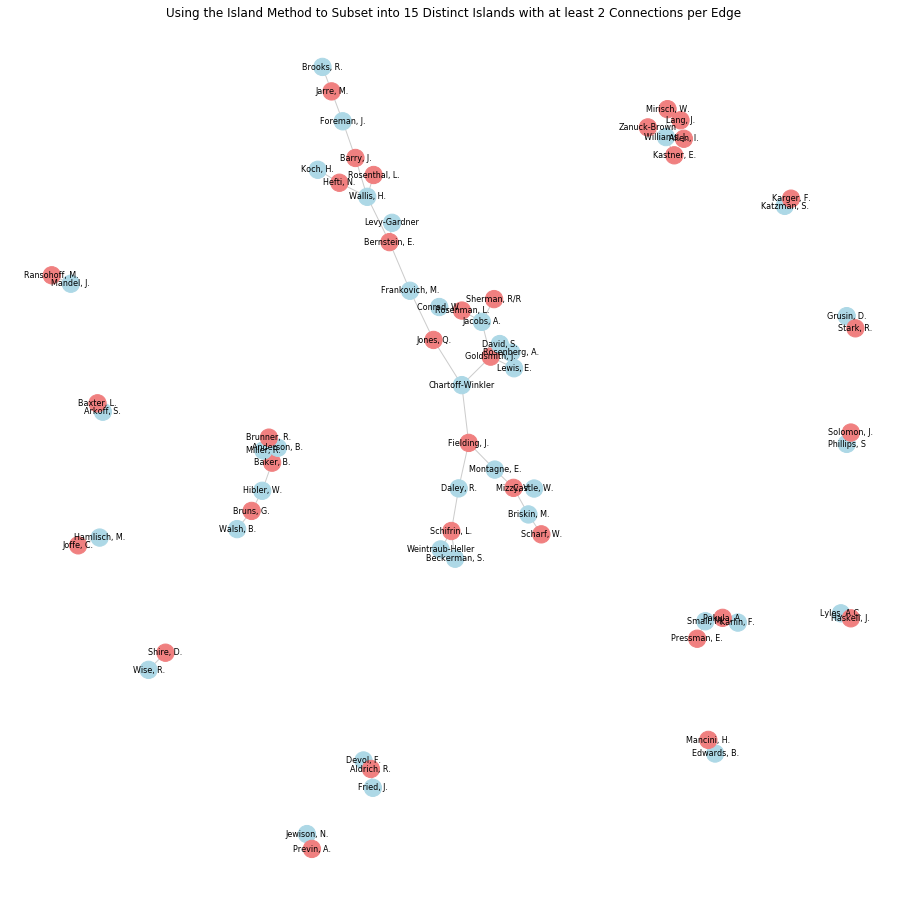

In [22]:
plt.rcParams['figure.figsize'] = [16, 16]
plt.title("Using the Island Method to Subset into 15 Distinct Islands with at least 2 Connections per Edge")
nx.draw(G, with_labels='true', node_color=comp_prod_col, font_size=8, edge_color='#cccccc')

### Inferences about the distinct groups

Now that our graph has been subsetted into multiple islands, we thought it would be interesting to disect the relationships and ego networks that comprise of these groups.

##### Measuring the number of connections of egonets -- radius of 2

Similar to what is outlined in our textbook, we first wanted to traverse each node and measure the size of the components for each. Therefore, we wrote a function to traverse our nodes, starting at each node, and measured the number of nodes that make up a producer/composer's immediate network with a radius equal to two.

In [23]:
reach = []
full_names = producers + composers

for i in full_names:
    if i in G.nodes:
        reach.append((i, len(nx.Graph(nx.ego_graph(G, i, radius=2)))))
    else:
        pass

Then, we created a dataframe of these values to see how many nodes make up each individual's immediate network, and sorted to show the top 4 producers/composers with the most connections. As we can see, Chartoff-Winkler, Goldsmith, Wallis, and Jacobs make up our list. This isn't much of a surprise given their position in our network visualization above -- all very central nodes, displaying connections to many other producers/composers in the network.

In [24]:
name = []
size = []

for i in reach:
    name.append(i[0])
    size.append(i[1])
    
network_df = pd.DataFrame({'Name': name, 'Network Size (rad=2)': size})
network_df.sort_values(by=['Network Size (rad=2)'], ascending=False).head(4).style.hide_index()

Name,Network Size (rad=2)
Chartoff-Winkler,11
"Goldsmith, J.",10
"Wallis, H.",9
"Jacobs, A.",9


We also displayed this visually, in our bipartite layout below, showing the connections between each of our top 4 producers/composers, and how connected they are to other composers and producers in the network.

In [25]:
def draw_egonet(network_list, i):
    subgraph = nx.Graph(nx.ego_graph(G, network_list[i], radius=2))
    return subgraph

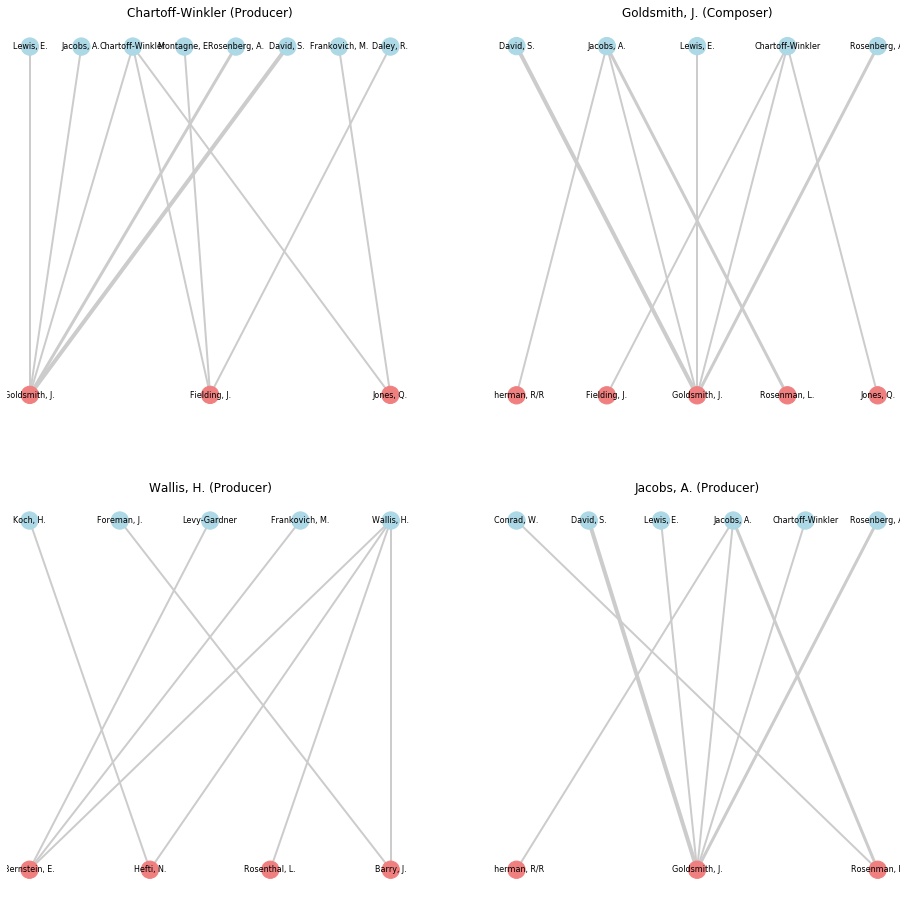

In [26]:
df_for_viz = network_df.sort_values(by=['Network Size (rad=2)'], ascending=False)


for i in range(1, 5):
    col_bipart = []
    weights = []
    subgraph = draw_egonet(list(df_for_viz['Name']), i-1)
    weights= [edata['weight'] for f,to,edata in subgraph.edges(data=True)]
#     col = bipartite.color(subgraph)
#     nx.set_node_attributes(subgraph, col, 'bipartite')
    color_nodes(subgraph, col_bipart)
    top = nx.bipartite.sets(subgraph)[0]
    pos = nx.bipartite_layout(subgraph,top, align='horizontal')
    plt.subplot(220 + i)
    plt.axis('off')
    #plt.title(title_list[i-1])
    name = str(df_for_viz.iloc[i-1]['Name'])
    if name in nx.bipartite.sets(g)[0]:
        typ = "(Producer)"
    else:
        typ = "(Composer)"
    titl = name + " " + typ 
    plt.title('%s' %titl)
    nx.draw_networkx(subgraph, pos, node_color=col_bipart, edgecolor='#bbbbbb', edge_color="#cccccc", font_size=8, width = weights)
    
plt.rcParams['figure.figsize'] = [18, 8]
plt.show() 

Interestingly, we can see that Chartoff-Winkler and Jacobs, two of our top producers, have collaborated with Jerry Goldsmith (Goldsmith, J.), which appears to have collaborated with a large network of other producers on films. Since we have our radius equal to two for this analysis, we can see how Goldsmith's collaborations with other producers affect this rank.

##### Dissecting our large, central cluster

In order to capture all of the nodes that are located in our central island cluster, we decided to start at one node and traverse out to all nodes connected in the network until we reached the maximum number of nodes in the island. To do this, we adapted our ego_graph function to determine when we reached the maximum number of nodes in our subgraph.

In [27]:
ego_graph_size = []
for i in range(1, 15):
    ego_graph_size.append((i, len(nx.Graph(nx.ego_graph(G, 'Chartoff-Winkler', radius=i)))))
    if (i != 1) & (int(ego_graph_size[i-2][1]) == int(ego_graph_size[i-1][1])):
        break
    else:
        continue

In [28]:
ego_graph_size

[(1, 4),
 (2, 11),
 (3, 16),
 (4, 23),
 (5, 27),
 (6, 29),
 (7, 30),
 (8, 31),
 (9, 31)]

As we can see from above, a radius of 8 will capture all 31 nodes in this subgraph. Therefore, we can isolate these nodes for analysis by using our ego_graph function with a radius of 8.

In [29]:
large_cluster = nx.Graph(nx.ego_graph(G, 'Goldsmith, J.', radius=8))

We can see this cluster below:

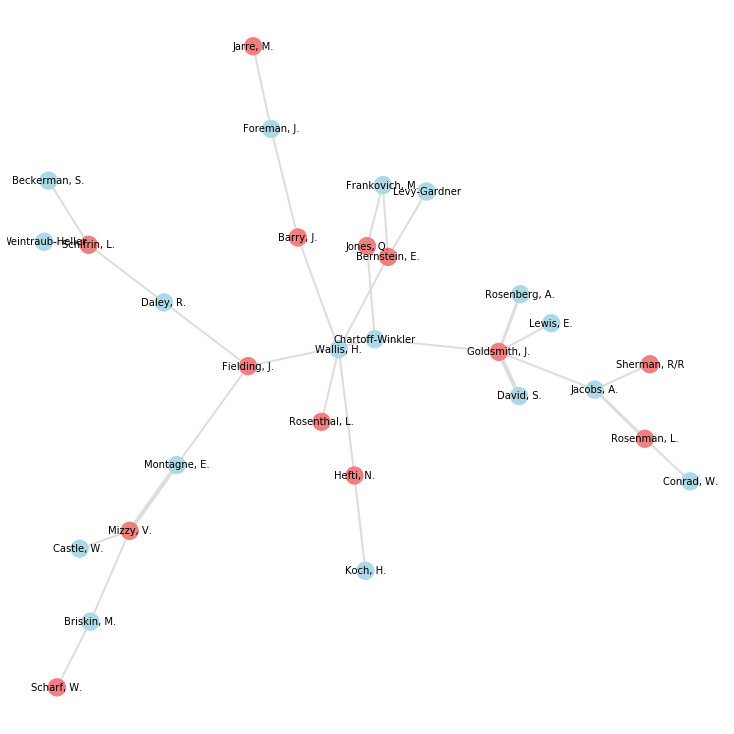

In [30]:
comp_prod_col_lg = []
c = bipartite.color(large_cluster)
weights =[]
nx.set_node_attributes(large_cluster, c, 'bipartite')
weights= [edata['weight'] for f,to,edata in large_cluster.edges(data=True)]

color_nodes(large_cluster, comp_prod_col_lg)
plt.rcParams['figure.figsize'] = [10, 10]
nx.draw(large_cluster, with_labels='True', node_color=comp_prod_col_lg, edge_color="#dddddd", width=weights, font_size=10)

We can take a look at some of the centrality measures for this subgraph, to see which composers and/or producers are more connected in this network.

In [31]:
large_cluster_cent = nx.degree_centrality(large_cluster)
large_cluster_cent = sorted(large_cluster_cent.items(), key=lambda x: x[1], reverse=True)

In [32]:
large_cluster_betw = nx.betweenness_centrality(large_cluster)
large_cluster_betw = sorted(large_cluster_betw.items(), key=lambda x: x[1], reverse=True)

In [33]:
between_df = pd.DataFrame(large_cluster_betw, columns=['Name', 'Betweenness Centrality'])
degree_df = pd.DataFrame(large_cluster_cent, columns=['Name', 'Degree Centrality'])

In [34]:
cluster_df = degree_df.merge(between_df, on='Name', how='left')
cluster_df.head().style.hide_index()

Name,Degree Centrality,Betweenness Centrality
"Goldsmith, J.",0.172414,0.416256
"Wallis, H.",0.137931,0.366995
"Bernstein, E.",0.103448,0.431034
"Schifrin, L.",0.103448,0.135468
Chartoff-Winkler,0.103448,0.684729


In [35]:
cluster_df.sort_values(by='Betweenness Centrality', ascending=False).head().style.hide_index()

Name,Degree Centrality,Betweenness Centrality
Chartoff-Winkler,0.103448,0.684729
"Fielding, J.",0.103448,0.492611
"Jones, Q.",0.068966,0.467980
"Frankovich, M.",0.068966,0.443350
"Bernstein, E.",0.103448,0.431034


The nodes sorted by highest degree centrality show Goldsmith, J. standing out with the highest value, but it important to note that he has connections to 3 Producers that no one else has worked with (at least twice). This means that the high degree centrality shouldn't necessarily contribute to a high betweenness centrality. Looking at the table sorted by betweenness, we can see that this is true. In fact, only one node from the first table is also present in the second: Chartoff-Winkler. 

Chartoff-Winkler's degree centraliy value was actually tied with 5 other nodes, so it does not stand out within the dataset in terms of that, but he has by far the highest betweenness centrality. Just by looking at the network, it is clear that Chartoff-Winkler holds the entire cluster together. He is the node that ties together 3 subgroupings into this one cluster through his work with Jones, Fielding and Goldsmith.

It's interesting to note that there aren't any "loops" in this network. Our cutoff of at least 2 interactions has highlighted that very few individuals repeatedly worked with more than 2 people. In fact, only 8 of the 31 nodes in this subgraph had more than 2 repeated connections. 

In [36]:
print(weights)
statistics.mean(weights)

[2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 4, 2, 3, 2, 2, 2, 2, 4, 2, 2, 2, 2]


2.2413793103448274

We can see here, that on average, there are about two collaborations between producers and composers in this subgraph. It'll be interesting to compare this average to some of our smaller networks, to see if there are differences between this larger subnetwork and others that work more in isolation.

##### Identifying smaller, isolated subgraphs in the network

###### Williams subgraph

With some interesting findings established from our larger subgraph with 31 nodes, we can move across the network to different islands that are less connected. For instance, we can take a look at an interesting cluster involving Williams, J. (producer), and his collaboration with 5 different composers on films between this time period. We can infer that Williams possibly wanted to seek out different styles of music for his films, and thus decided to branch out to different composers to find what he was looking for.

In [37]:
williams_cluster = nx.Graph(nx.ego_graph(G, 'Williams, J.', radius=2))

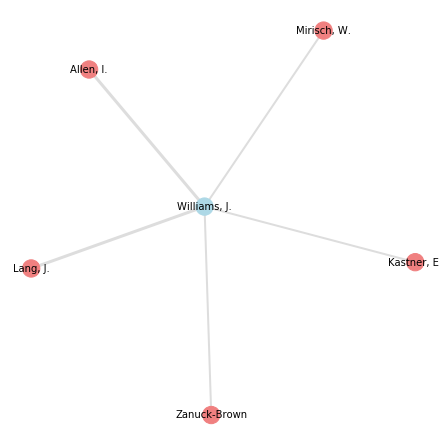

In [38]:
comp_prod_col_williams = []
c = bipartite.color(williams_cluster)
nx.set_node_attributes(williams_cluster, c, 'bipartite')
williams_weights= [edata['weight'] for f,to,edata in williams_cluster.edges(data=True)]

color_nodes(williams_cluster, comp_prod_col_williams)
plt.rcParams['figure.figsize'] = [6, 6]
nx.draw(williams_cluster, with_labels='True', node_color=comp_prod_col_williams, edge_color="#dddddd", width=williams_weights, font_size=10)

In [39]:
statistics.mean(williams_weights)

2.4

On average, it looks like Williams exceeded the minimum of 2 collaborations only twice in his network of 5 interactions.

##### Baker, Anderson, Brunner & Miller subgraph

Another interesting subgraph that we can explore is through the collaborations between Baker, Anderson, Miller, and Brunner. We can see here that there was a large number of collaborations on films between the composer/producer duos in this set of four.

In [40]:
hibler_cluster = nx.Graph(nx.ego_graph(G, 'Hibler, W.', radius=3))

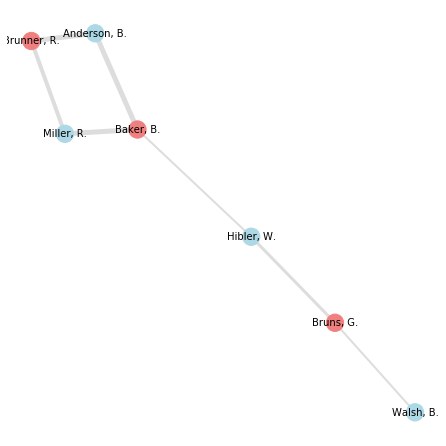

In [41]:
comp_prod_col_hibler = []
c = bipartite.color(hibler_cluster)
nx.set_node_attributes(hibler_cluster, c, 'bipartite')
hibler_weights= [edata['weight'] for f,to,edata in hibler_cluster.edges(data=True)]

color_nodes(hibler_cluster, comp_prod_col_hibler)
plt.rcParams['figure.figsize'] = [6, 6]
nx.draw(hibler_cluster, with_labels='True', node_color=comp_prod_col_hibler, edge_color="#dddddd", width=hibler_weights, font_size=10)

In [42]:
hibler_weights

[2, 3, 2, 5, 4, 5, 5]

In [43]:
statistics.mean(hibler_weights)

3.7142857142857144

This sub-network has a higher average weight, driven largely by the tight-knit quad created by both Brunner and Baker enjoying repeatedly working with Miller and Anderson. 

### Conclusions

The world of movie scores is a very complicated network of Producers and Composers. Looking at only collaborations on at least two occasions, we can see a spattering of 2 or 3-people networks, and three networks consisting of more than 5 individuals. The largest sub-network consists of 31 individuals, but even here the predominant number of repeated collaborations is 2. It seems very rare that a producer and a composer would work together more than 2 times (only 5 times within the largest network).

If we were to change the cutoff of our islands evaluation to being above 2 interactions, the number of islands only decreases from 15 to 14 (to 10 with an increase of the threshold to 3). The number of nodes included in this subset would however drop from 71 to 34 (22 at threshold of 3). This indicates that all but of the small networks (all but 1) contain at least one interaction of at least 3 connections. The smaller subnetworks seem to be very tight-knit pairs (or threes) that stem from successful Producer-Composer partnerships. 

Interestingly enough, the largest subgraph generated by our island method contained a maximum connection weight of 4, despite the highest weight in the overall network being 8. Looking at the summary of the island breakdown, we see that there is one pair that worked together 8 times, two additional pairs that collaborated 7 times and one more - 6 times. None of these pairings were within the three larger subgraphs we looked at, so they must all be one of the very small 2 or 3 person groupings - suggesting several incredibly tight partnerships where the individuals rarely (if ever) branch out.

It seems like there is one large central network of people collaborating, though it seems something of a product of random connections as opposed to a truly connected network - otherwise one would expect to see more "loops" in the structure of the network with producers recommending composers for collaboration to their colleagues and vice-versa. Instead we see a fairly linear structure padded out by individuals with multiple collaborations. The "true" networks seem to be very small, with individual pairs working together many times and not branching out much.  